In [1]:
import pandas as pd
import numpy as np
import torch
from datetime import datetime

In [2]:
chartLab48 = pd.read_csv("../Code/output/chartLab48Item20.csv")

In [3]:
patients = pd.read_csv("../Code/output/patientsinfo.csv")

In [4]:
patients.head()

,SUBJECT_ID,HADM_ID,Age,GENDER,HOSPITAL_EXPIRE_FLAG
0,22,165315,64.97,F,0
1,23,152223,71.18,M,0
2,23,124321,75.31,M,0
3,24,161859,39.04,M,0
4,25,129635,58.99,M,0


In [5]:
patients[['GENDER_num']] = patients['GENDER'].apply(lambda x: 0 if x=='M' else 1)

In [6]:
patients.head()

,SUBJECT_ID,HADM_ID,Age,GENDER,HOSPITAL_EXPIRE_FLAG,GENDER_num
0,22,165315,64.97,F,0,1
1,23,152223,71.18,M,0,0
2,23,124321,75.31,M,0,0
3,24,161859,39.04,M,0,0
4,25,129635,58.99,M,0,0


In [7]:
chartLab48.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00


In [8]:
chartLab48.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18920178 entries, 0 to 18920177
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 721.7+ MB


# Data cleaning

In [9]:
def chart_cleaning(df):
    # GLU
    df = df.drop(df[(df.ITEMID=='GLU') & (df.VALUE>5000)].index)
    # DBP
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='DBP') & (df.VALUE<0)].index)
    # FIO -- ignore
    # df = df.drop(df[(df.ITEMID=='FIO') & (df.VALUE>100)].index)
    # HEIGHT
    df = df.drop(df[(df.ITEMID=='HEIGHT') & (df.VALUE>300)].index)
    # HR
    df = df.drop(df[(df.ITEMID=='HR') & (df.VALUE>10000)].index)
    # MBP
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE>1000)].index)
    df = df.drop(df[(df.ITEMID=='MBP') & (df.VALUE<0)].index)
    # OS
    df = df.drop(df[(df.ITEMID=='OS') & (df.VALUE>10000)].index)
    # PH
    df = df.drop(df[(df.ITEMID=='PH') & (df.VALUE>10)].index) 
    # RESPR
    df = df.drop(df[(df.ITEMID=='RESPR') & (df.VALUE>1000)].index)
    # SBP
    df = df.drop(df[(df.ITEMID=='SBP') & (df.VALUE>1000)].index)
    # TEMP
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE>50)].index) 
    df = df.drop(df[(df.ITEMID=='TEMP') & (df.VALUE<20)].index)
    # weight
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE>1000)].index) 
    df = df.drop(df[(df.ITEMID=='WEIGHT') & (df.VALUE<10)].index)

    return df

In [10]:
chartLab48 = chart_cleaning(chartLab48)

In [11]:
chartLab48.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18917320 entries, 0 to 18920177
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   CHARTTIME   object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 866.0+ MB


# Data preprocessing

In [12]:
chartLab48[['TIME']] = chartLab48['CHARTTIME'].apply(lambda x: x[:10] +' '+ x[11:13])

In [13]:
chartLab48.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,TIME
0,36,165660,FIO,2134-05-12T12:00:00.000-04:00,100.00,2134-05-12 12
1,36,165660,PH,2134-05-12T12:35:00.000-04:00,7.29,2134-05-12 12
2,36,165660,HR,2134-05-12T13:00:00.000-04:00,86.00,2134-05-12 13
3,36,165660,SBP,2134-05-12T13:00:00.000-04:00,137.00,2134-05-12 13
4,36,165660,DBP,2134-05-12T13:00:00.000-04:00,72.00,2134-05-12 13


In [14]:
chartLab48_hourly = chartLab48[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'TIME']].groupby(['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'TIME'], as_index=False).mean()

In [15]:
chartLab48_hourly.head()

,SUBJECT_ID,HADM_ID,ITEMID,TIME,VALUE
0,3,145834,DBP,2101-10-20 18,24.000000
1,3,145834,DBP,2101-10-20 19,36.200000
2,3,145834,DBP,2101-10-20 20,47.125000
3,3,145834,DBP,2101-10-20 21,44.375000
4,3,145834,DBP,2101-10-20 22,67.666667


In [16]:
chartLab48_hourly.info() ## 13786286 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13786286 entries, 0 to 13786285
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   SUBJECT_ID  int64  
 1   HADM_ID     int64  
 2   ITEMID      object 
 3   TIME        object 
 4   VALUE       float64
dtypes: float64(1), int64(2), object(2)
memory usage: 631.1+ MB


In [17]:
items20 = chartLab48['ITEMID'].unique()

In [18]:
items20

array(['FIO', 'PH', 'HR', 'SBP', 'DBP', 'MBP', 'RESPR', 'OS', 'TEMP',
       'WEIGHT', 'GLU', 'HEIGHT', 'GO', 'GT', 'GMR', 'GVR', 'CRR', 'POTA',
       'UREA', 'WBC'], dtype=object)

In [19]:
chartLab48_hourly_pivot = chartLab48_hourly.pivot(index = ['HADM_ID', 'TIME'],columns='ITEMID', values = 'VALUE')

In [20]:
chartLab48_hourly_pivot.tail()

ITEMID                 CRR   DBP   FIO  GLU  GMR   GO  GT  GVR  HEIGHT    HR  \
HADM_ID TIME                                                                   
199999  2136-04-08 12  NaN  54.0  50.0  NaN  6.0  4.0 NaN  5.0     NaN  72.0   
        2136-04-08 13  NaN  93.0   NaN  NaN  NaN  NaN NaN  NaN     NaN  76.0   
        2136-04-08 14  NaN  55.0   NaN  NaN  NaN  NaN NaN  NaN     NaN  73.0   
        2136-04-08 15  NaN  50.0  50.0  NaN  NaN  NaN NaN  NaN     NaN  75.0   
        2136-04-08 16  NaN  64.0   NaN  NaN  6.0  4.0 NaN  5.0     NaN  76.0   

ITEMID                  MBP    OS  PH  POTA  RESPR    SBP  TEMP  UREA  WBC  \
HADM_ID TIME                                                                 
199999  2136-04-08 12  77.0  95.0 NaN   NaN   23.0  148.0   NaN   NaN  NaN   
        2136-04-08 13  96.0  94.0 NaN   NaN   29.0  129.0   NaN   NaN  NaN   
        2136-04-08 14  80.0  95.0 NaN   NaN   19.0  151.0   NaN   NaN  NaN   
        2136-04-08 15  71.0  92.0 NaN   NaN   25.0  131.0   NaN   NaN  NaN   
        2136-04-08 16  80.0  93.0 NaN   NaN   21.0  136.0  36.5   NaN  NaN   

ITEMID                 WEIGHT  
HADM_ID TIME                   
199999  2136-04-08 12     NaN  
        2136-04-08 13     NaN  
        2136-04-08 14     NaN  
        2136-04-08 15     NaN  
        2136-04-08 16     NaN

In [21]:
chartLab48_hourly_pivot2 = chartLab48_hourly_pivot.reset_index()

In [22]:
chartLab48_hourly_pivot2.head()

ITEMID,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,MBP,OS,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,98.01
1,100001,2117-09-11 13,NaN,100.0,NaN,NaN,6.0,4.0,NaN,5.0,...,122.0,NaN,NaN,NaN,22.0,192.0,36.666667,NaN,NaN,NaN
2,100001,2117-09-11 14,NaN,85.0,NaN,208.0,NaN,NaN,NaN,NaN,...,103.0,NaN,NaN,4.2,15.0,165.0,NaN,42.0,NaN,NaN
3,100001,2117-09-11 15,NaN,64.0,NaN,179.5,NaN,NaN,NaN,NaN,...,76.0,NaN,NaN,NaN,15.0,119.0,NaN,NaN,NaN,NaN
4,100001,2117-09-11 16,NaN,84.0,NaN,170.0,6.0,4.0,NaN,5.0,...,105.0,100.0,NaN,NaN,16.0,169.0,36.611111,NaN,NaN,NaN


In [23]:
chartLab48_hourly_pivot2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1748699 entries, 0 to 1748698
Data columns (total 22 columns):
 #   Column   Dtype  
---  ------   -----  
 0   HADM_ID  int64  
 1   TIME     object 
 2   CRR      float64
 3   DBP      float64
 4   FIO      float64
 5   GLU      float64
 6   GMR      float64
 7   GO       float64
 8   GT       float64
 9   GVR      float64
 10  HEIGHT   float64
 11  HR       float64
 12  MBP      float64
 13  OS       float64
 14  PH       float64
 15  POTA     float64
 16  RESPR    float64
 17  SBP      float64
 18  TEMP     float64
 19  UREA     float64
 20  WBC      float64
 21  WEIGHT   float64
dtypes: float64(20), int64(1), object(1)
memory usage: 293.5+ MB


In [24]:
# join the patients gender and age
chartLab48_hourly_pivot2 = chartLab48_hourly_pivot2.set_index('HADM_ID').join(patients[['HADM_ID', 'Age', 'GENDER_num']].set_index('HADM_ID'), how='inner')


In [25]:
chartLab48_hourly_pivot2.reset_index(inplace=True)

In [26]:
chartLab48_hourly_pivot2.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14.0,NaN,NaN,NaN,NaN,98.01,35.5,1
1,100001,2117-09-11 13,NaN,100.0,NaN,NaN,6.0,4.0,NaN,5.0,...,NaN,NaN,22.0,192.0,36.666667,NaN,NaN,NaN,35.5,1
2,100001,2117-09-11 14,NaN,85.0,NaN,208.0,NaN,NaN,NaN,NaN,...,NaN,4.2,15.0,165.0,NaN,42.0,NaN,NaN,35.5,1
3,100001,2117-09-11 15,NaN,64.0,NaN,179.5,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,119.0,NaN,NaN,NaN,NaN,35.5,1
4,100001,2117-09-11 16,NaN,84.0,NaN,170.0,6.0,4.0,NaN,5.0,...,NaN,NaN,16.0,169.0,36.611111,NaN,NaN,NaN,35.5,1


In [27]:
chartLab48_norm = chartLab48_hourly_pivot2.copy()

In [28]:
for col in chartLab48_norm.columns[2:]:
    chartLab48_norm[[col]] = (chartLab48_norm[[col]] - chartLab48_norm[[col]].min())/(chartLab48_norm[[col]].max()-chartLab48_norm[[col]].min())
    

In [29]:
chartLab48_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.033466,NaN,NaN,NaN,NaN,0.095663,0.05957,1.0
1,100001,2117-09-11 13,NaN,0.104058,NaN,NaN,1.0,1.0,NaN,1.0,...,NaN,NaN,0.052590,0.467153,0.739448,NaN,NaN,NaN,0.05957,1.0
2,100001,2117-09-11 14,NaN,0.088450,NaN,0.129485,NaN,NaN,NaN,NaN,...,NaN,0.012898,0.035857,0.401460,NaN,0.155556,NaN,NaN,0.05957,1.0
3,100001,2117-09-11 15,NaN,0.066597,NaN,0.118370,NaN,NaN,NaN,NaN,...,NaN,NaN,0.035857,0.289538,NaN,NaN,NaN,NaN,0.05957,1.0
4,100001,2117-09-11 16,NaN,0.087409,NaN,0.114665,1.0,1.0,NaN,1.0,...,NaN,NaN,0.038247,0.411192,0.736843,NaN,NaN,NaN,0.05957,1.0


In [30]:
# fill null with -1
chartLab48_norm.fillna(-1, inplace=True)

In [31]:
chartLab48_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,PH,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000000,0.033466,-1.000000,-1.000000,-1.000000,-1.0,0.095663,0.05957,1.0
1,100001,2117-09-11 13,-1.0,0.104058,-1.0,-1.000000,1.0,1.0,-1.0,1.0,...,-1.0,-1.000000,0.052590,0.467153,0.739448,-1.000000,-1.0,-1.000000,0.05957,1.0
2,100001,2117-09-11 14,-1.0,0.088450,-1.0,0.129485,-1.0,-1.0,-1.0,-1.0,...,-1.0,0.012898,0.035857,0.401460,-1.000000,0.155556,-1.0,-1.000000,0.05957,1.0
3,100001,2117-09-11 15,-1.0,0.066597,-1.0,0.118370,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.000000,0.035857,0.289538,-1.000000,-1.000000,-1.0,-1.000000,0.05957,1.0
4,100001,2117-09-11 16,-1.0,0.087409,-1.0,0.114665,1.0,1.0,-1.0,1.0,...,-1.0,-1.000000,0.038247,0.411192,0.736843,-1.000000,-1.0,-1.000000,0.05957,1.0


In [32]:
chartLab48_norm[['value']] = chartLab48_norm.apply(lambda x: list(x['CRR':]), axis=1)

In [33]:
chartLab48_norm.head()

,HADM_ID,TIME,CRR,DBP,FIO,GLU,GMR,GO,GT,GVR,...,POTA,RESPR,SBP,TEMP,UREA,WBC,WEIGHT,Age,GENDER_num,value
0,100001,2117-09-11 12,-1.0,-1.000000,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,...,-1.000000,0.033466,-1.000000,-1.000000,-1.000000,-1.0,0.095663,0.05957,1.0,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
1,100001,2117-09-11 13,-1.0,0.104058,-1.0,-1.000000,1.0,1.0,-1.0,1.0,...,-1.000000,0.052590,0.467153,0.739448,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.1040582726326743, -1.0, -1.0, 1.0, 1...."
2,100001,2117-09-11 14,-1.0,0.088450,-1.0,0.129485,-1.0,-1.0,-1.0,-1.0,...,0.012898,0.035857,0.401460,-1.000000,0.155556,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.08844953173777315, -1.0, 0.1294851794..."
3,100001,2117-09-11 15,-1.0,0.066597,-1.0,0.118370,-1.0,-1.0,-1.0,-1.0,...,-1.000000,0.035857,0.289538,-1.000000,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.06659729448491156, -1.0, 0.1183697347..."
4,100001,2117-09-11 16,-1.0,0.087409,-1.0,0.114665,1.0,1.0,-1.0,1.0,...,-1.000000,0.038247,0.411192,0.736843,-1.000000,-1.0,-1.000000,0.05957,1.0,"[-1.0, 0.08740894901144641, -1.0, 0.1146645865..."


In [34]:
chartLab48_grouped = chartLab48_norm[['HADM_ID', 'value']].groupby('HADM_ID').agg(lambda x: list(x))

In [38]:
chartLab48_grouped[['num_stamps']] = chartLab48_grouped['value'].apply(lambda x: len(x))

In [39]:
chartLab48_grouped.head()

,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",48
100003,"[[-1.0, 0.037460978147762745, -1.0, 0.07020280...",44
100006,"[[-1.0, 0.08949011446409989, -1.0, -1.0, 1.0, ...",48
100007,"[[-1.0, 0.06659729448491156, -1.0, 0.093213728...",33
100009,"[[-1.0, -1.0, -1.0, 0.09126365054602184, -1.0,...",45


In [40]:
chartLab48_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46237 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       46237 non-null  object
 1   num_stamps  46237 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [41]:
# remove the admissions which has more than 30 timestamps
chartLab48_grouped.drop(chartLab48_grouped[chartLab48_grouped['num_stamps']>60].index, inplace=True)

In [42]:
chartLab48_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46225 entries, 100001 to 199999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   value       46225 non-null  object
 1   num_stamps  46225 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [43]:
chartLab48_grouped.head()

,value,num_stamps
HADM_ID,,
100001,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",48
100003,"[[-1.0, 0.037460978147762745, -1.0, 0.07020280...",44
100006,"[[-1.0, 0.08949011446409989, -1.0, -1.0, 1.0, ...",48
100007,"[[-1.0, 0.06659729448491156, -1.0, 0.093213728...",33
100009,"[[-1.0, -1.0, -1.0, 0.09126365054602184, -1.0,...",45


In [44]:
chartLab48_valueWithLabel = chartLab48_grouped[['value']].join(patients[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']].set_index('HADM_ID'), how='inner')


In [45]:
# split the data to train and test
chartLab48_shuffle = chartLab48_valueWithLabel.sample(frac=1)
chartLab48_test = chartLab48_shuffle.iloc[:7000, ]
chartLab48_valid = chartLab48_shuffle.iloc[7001:14000, ]
chartLab48_train = chartLab48_shuffle.iloc[14001: ,]


In [46]:
# process train dataset
train_label = chartLab48_train['HOSPITAL_EXPIRE_FLAG'].tolist()
train_data = chartLab48_train['value'].tolist()


'\npack the data which has less than 30 timestamp\ntrain_data_seqs = []\npack_list = [-1]*17\n\nfor a in train_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        train_data_seqs.append(a)\n    else:\n        train_data_seqs.append(a)\n\n'

In [47]:
# process validation dataset
valid_label = chartLab48_valid['HOSPITAL_EXPIRE_FLAG'].tolist()
valid_data = chartLab48_valid['value'].tolist()


'\n# pack the data which has less than 30 timestamp\nvalid_data_seqs = []\npack_list = [-1]*17\n\nfor a in valid_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        valid_data_seqs.append(a)\n    else:\n        valid_data_seqs.append(a)\n     \n'

In [48]:
# process test dataset
test_label = chartLab48_test['HOSPITAL_EXPIRE_FLAG'].tolist()
test_data = chartLab48_test['value'].tolist()


'\ntest_data_seqs = []\npack_list = [-1]*17\nfor a in test_data:\n    if len(a)<30:\n        num = len(a)\n        a.extend([pack_list]*(30-num))\n        test_data_seqs.append(a)\n    else:\n        test_data_seqs.append(a)\n     \n'

# RNN model

In [50]:
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset

from utils import train, evaluate
from plots import plot_learning_curves, plot_confusion_matrix

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [51]:
class MyVariableRNN(nn.Module):
	def __init__(self, dim_input):
		super(MyVariableRNN, self).__init__()
		# You may use the input argument 'dim_input', which is basically the number of features

		self.fc1 = nn.Linear(in_features = dim_input , out_features = 32)
		self.rnn = nn.GRU(input_size = 32, hidden_size=16, num_layers=2, batch_first=True, dropout=0.5)
		self.fc2 = nn.Linear(in_features = 16, out_features = 2)
       

	def forward(self, input_tuple):
		# HINT: Following two methods might be useful
		# 'pack_padded_sequence' and 'pad_packed_sequence' from torch.nn.utils.rnn
		seqs, lengths = input_tuple
       
		seqs = torch.tanh(self.fc1(seqs))
                            
		seqs = pack_padded_sequence(seqs, lengths=lengths, batch_first=True)
		seqs, _ = self.rnn(seqs)
        
		seqs, _ = pad_packed_sequence(seqs, batch_first=True)
		idx = (torch.LongTensor(lengths) - 1).view(-1, 1).expand(len(lengths), seqs.size(2))
		idx = idx.unsqueeze(1)
		last_output = seqs.gather(1, Variable(idx)).squeeze(1)       
     
		seqs = self.fc2(last_output)
        
		return seqs

In [52]:
class VisitSequenceWithLabelDataset(Dataset):
	def __init__(self, seqs, labels, num_features):
		"""
		Args:
			seqs (list): list of patients (list) of visits (list) of codes (int) that contains visit sequences
			labels (list): list of labels (int)
			num_features (int): number of total features available
		"""

		if len(seqs) != len(labels):
			raise ValueError("Seqs and Labels have different lengths")

		self.labels = labels
		self.seqs=[]        
		for i in seqs:
			i_matrix = np.asarray(i)
			self.seqs.append(i_matrix)
             

	def __len__(self):
		return len(self.labels)

	def __getitem__(self, index):
		# returns will be wrapped as List of Tensor(s) by DataLoader
		return self.seqs[index], self.labels[index]



In [53]:
def visit_collate_fn(batch):
	"""
	DataLoaderIter call - self.collate_fn([self.dataset[i] for i in indices])
	Thus, 'batch' is a list [(seq_1, label_1), (seq_2, label_2), ... , (seq_N, label_N)]
	where N is minibatch size, seq_i is a Numpy (or Scipy Sparse) array, and label is an int value

	:returns
		seqs (FloatTensor) - 3D of batch_size X max_length X num_features
		lengths (LongTensor) - 1D of batch_size
		labels (LongTensor) - 1D of batch_size
	"""

	# TODO: Return the following two things
	# TODO: 1. a tuple of (Tensor contains the sequence data , Tensor contains the length of each sequence),
	# TODO: 2. Tensor contains the label of each sequence
	n_features = 22

	batch_len = [(i[0], i[1], len(i[0])) for i in batch]    
	max_len = np.max([i[2] for i in batch_len])

	batch_len_com = [(np.append(i[0], -np.ones(((max_len-i[2]), n_features)), axis=0), i[1], i[2]) for i in batch_len]
	batch_len_com_sort = sorted(batch_len_com, key= lambda x: -x[2])    
	segs = [i[0] for i in batch_len_com_sort]
	lengths = [i[2] for i in batch_len_com_sort]
	labels = [i[1] for i in batch_len_com_sort]   
	    
	seqs_tensor = torch.FloatTensor(segs)
	lengths_tensor = torch.LongTensor(lengths)
	labels_tensor = torch.LongTensor(labels)

	return (seqs_tensor, lengths_tensor), labels_tensor



In [54]:
# train RNN model
PATH_OUTPUT = "../output/mortality/"
os.makedirs(PATH_OUTPUT, exist_ok=True)

NUM_EPOCHS = 20
BATCH_SIZE = 64
NUM_WORKERS = 2

device = torch.device("cuda" if torch.cuda.is_available() and USE_CUDA else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

num_features = 22

train_dataset = VisitSequenceWithLabelDataset(train_data, train_label, num_features)
valid_dataset = VisitSequenceWithLabelDataset(valid_data, valid_label, num_features)
test_dataset = VisitSequenceWithLabelDataset(test_data, test_label, num_features)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)
# batch_size for the test set should be 1 to avoid sorting each mini-batch which breaks the connection with patient IDs
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, collate_fn=visit_collate_fn, num_workers=NUM_WORKERS)

In [55]:
test_dataset[3][0].shape

(50, 22)

Epoch: [0][0/504]	Time 0.170 (0.170)	Data 0.104 (0.104)	Loss 0.6888 (0.6888)	Accuracy 53.000 (53.000)
Epoch: [0][10/504]	Time 0.048 (0.060)	Data 0.001 (0.010)	Loss 0.4900 (0.5835)	Accuracy 89.000 (85.273)
Epoch: [0][20/504]	Time 0.049 (0.058)	Data 0.001 (0.006)	Loss 0.3996 (0.5197)	Accuracy 89.000 (86.429)
Epoch: [0][30/504]	Time 0.052 (0.057)	Data 0.001 (0.004)	Loss 0.3207 (0.4710)	Accuracy 90.000 (87.129)
Epoch: [0][40/504]	Time 0.046 (0.055)	Data 0.001 (0.003)	Loss 0.3071 (0.4321)	Accuracy 90.000 (87.902)
Epoch: [0][50/504]	Time 0.051 (0.053)	Data 0.001 (0.003)	Loss 0.3756 (0.4198)	Accuracy 87.000 (87.784)
Epoch: [0][60/504]	Time 0.046 (0.053)	Data 0.001 (0.003)	Loss 0.2452 (0.4007)	Accuracy 93.000 (88.262)
Epoch: [0][70/504]	Time 0.051 (0.052)	Data 0.001 (0.002)	Loss 0.2086 (0.3940)	Accuracy 95.000 (88.254)
Epoch: [0][80/504]	Time 0.055 (0.052)	Data 0.001 (0.002)	Loss 0.3223 (0.3912)	Accuracy 90.000 (88.148)
Epoch: [0][90/504]	Time 0.054 (0.051)	Data 0.001 (0.002)	Loss 0.3965 (0.38

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type MyVariableRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: [1][0/504]	Time 0.135 (0.135)	Data 0.070 (0.070)	Loss 0.1924 (0.1924)	Accuracy 93.000 (93.000)
Epoch: [1][10/504]	Time 0.056 (0.066)	Data 0.001 (0.007)	Loss 0.1915 (0.2193)	Accuracy 92.000 (91.636)
Epoch: [1][20/504]	Time 0.048 (0.059)	Data 0.001 (0.004)	Loss 0.2127 (0.2285)	Accuracy 92.000 (91.048)
Epoch: [1][30/504]	Time 0.049 (0.056)	Data 0.001 (0.003)	Loss 0.2209 (0.2359)	Accuracy 92.000 (90.645)
Epoch: [1][40/504]	Time 0.052 (0.055)	Data 0.001 (0.003)	Loss 0.1797 (0.2358)	Accuracy 95.000 (90.829)
Epoch: [1][50/504]	Time 0.049 (0.054)	Data 0.001 (0.002)	Loss 0.2175 (0.2341)	Accuracy 90.000 (90.980)
Epoch: [1][60/504]	Time 0.053 (0.054)	Data 0.001 (0.002)	Loss 0.3790 (0.2389)	Accuracy 87.000 (90.967)
Epoch: [1][70/504]	Time 0.054 (0.054)	Data 0.001 (0.002)	Loss 0.2006 (0.2427)	Accuracy 93.000 (90.761)
Epoch: [1][80/504]	Time 0.057 (0.054)	Data 0.001 (0.002)	Loss 0.2219 (0.2475)	Accuracy 87.000 (90.432)
Epoch: [1][90/504]	Time 0.064 (0.054)	Data 0.001 (0.002)	Loss 0.2594 (0.25

Epoch: [2][260/504]	Time 0.054 (0.056)	Data 0.001 (0.001)	Loss 0.1332 (0.2365)	Accuracy 96.000 (90.916)
Epoch: [2][270/504]	Time 0.057 (0.056)	Data 0.001 (0.001)	Loss 0.3491 (0.2369)	Accuracy 85.000 (90.889)
Epoch: [2][280/504]	Time 0.054 (0.056)	Data 0.001 (0.001)	Loss 0.1433 (0.2362)	Accuracy 93.000 (90.918)
Epoch: [2][290/504]	Time 0.055 (0.056)	Data 0.001 (0.001)	Loss 0.2762 (0.2373)	Accuracy 93.000 (90.859)
Epoch: [2][300/504]	Time 0.055 (0.056)	Data 0.001 (0.001)	Loss 0.2433 (0.2366)	Accuracy 92.000 (90.890)
Epoch: [2][310/504]	Time 0.056 (0.056)	Data 0.001 (0.001)	Loss 0.2729 (0.2364)	Accuracy 92.000 (90.929)
Epoch: [2][320/504]	Time 0.056 (0.056)	Data 0.001 (0.001)	Loss 0.1145 (0.2364)	Accuracy 95.000 (90.928)
Epoch: [2][330/504]	Time 0.054 (0.056)	Data 0.001 (0.001)	Loss 0.3141 (0.2368)	Accuracy 92.000 (90.918)
Epoch: [2][340/504]	Time 0.053 (0.056)	Data 0.001 (0.001)	Loss 0.1579 (0.2360)	Accuracy 95.000 (90.938)
Epoch: [2][350/504]	Time 0.055 (0.056)	Data 0.001 (0.001)	Loss 0

Test: [50/110]	Time 0.010 (0.012)	Loss 0.2412 (0.2339)	Accuracy 92.000 (90.941)
Test: [100/110]	Time 0.011 (0.012)	Loss 0.1042 (0.2324)	Accuracy 96.000 (90.594)
Epoch: [4][0/504]	Time 0.112 (0.112)	Data 0.048 (0.048)	Loss 0.1528 (0.1528)	Accuracy 96.000 (96.000)
Epoch: [4][10/504]	Time 0.060 (0.064)	Data 0.001 (0.005)	Loss 0.3033 (0.2136)	Accuracy 85.000 (91.455)
Epoch: [4][20/504]	Time 0.053 (0.059)	Data 0.001 (0.003)	Loss 0.2156 (0.2194)	Accuracy 92.000 (91.762)
Epoch: [4][30/504]	Time 0.056 (0.058)	Data 0.001 (0.002)	Loss 0.2490 (0.2236)	Accuracy 90.000 (91.484)
Epoch: [4][40/504]	Time 0.054 (0.057)	Data 0.001 (0.002)	Loss 0.2381 (0.2238)	Accuracy 90.000 (91.537)
Epoch: [4][50/504]	Time 0.052 (0.057)	Data 0.001 (0.002)	Loss 0.2503 (0.2243)	Accuracy 90.000 (91.510)
Epoch: [4][60/504]	Time 0.055 (0.057)	Data 0.001 (0.002)	Loss 0.2149 (0.2225)	Accuracy 93.000 (91.475)
Epoch: [4][70/504]	Time 0.056 (0.057)	Data 0.001 (0.002)	Loss 0.2185 (0.2221)	Accuracy 93.000 (91.521)
Epoch: [4][80/50

Epoch: [5][250/504]	Time 0.062 (0.055)	Data 0.001 (0.001)	Loss 0.1722 (0.2187)	Accuracy 95.000 (91.375)
Epoch: [5][260/504]	Time 0.052 (0.055)	Data 0.001 (0.001)	Loss 0.1890 (0.2197)	Accuracy 96.000 (91.318)
Epoch: [5][270/504]	Time 0.056 (0.055)	Data 0.001 (0.001)	Loss 0.1535 (0.2189)	Accuracy 93.000 (91.343)
Epoch: [5][280/504]	Time 0.053 (0.055)	Data 0.001 (0.001)	Loss 0.1647 (0.2193)	Accuracy 96.000 (91.388)
Epoch: [5][290/504]	Time 0.053 (0.055)	Data 0.001 (0.001)	Loss 0.3567 (0.2199)	Accuracy 87.000 (91.375)
Epoch: [5][300/504]	Time 0.050 (0.055)	Data 0.001 (0.001)	Loss 0.3456 (0.2206)	Accuracy 84.000 (91.362)
Epoch: [5][310/504]	Time 0.054 (0.055)	Data 0.001 (0.001)	Loss 0.1466 (0.2198)	Accuracy 96.000 (91.424)
Epoch: [5][320/504]	Time 0.051 (0.055)	Data 0.001 (0.001)	Loss 0.1360 (0.2196)	Accuracy 93.000 (91.442)
Epoch: [5][330/504]	Time 0.057 (0.055)	Data 0.001 (0.001)	Loss 0.2747 (0.2198)	Accuracy 89.000 (91.429)
Epoch: [5][340/504]	Time 0.054 (0.055)	Data 0.001 (0.001)	Loss 0

Test: [0/110]	Time 0.072 (0.072)	Loss 0.3989 (0.3989)	Accuracy 82.000 (82.000)
Test: [50/110]	Time 0.009 (0.012)	Loss 0.2504 (0.2269)	Accuracy 92.000 (91.118)
Test: [100/110]	Time 0.010 (0.011)	Loss 0.0734 (0.2230)	Accuracy 98.000 (91.396)
Epoch: [7][0/504]	Time 0.102 (0.102)	Data 0.044 (0.044)	Loss 0.2337 (0.2337)	Accuracy 90.000 (90.000)
Epoch: [7][10/504]	Time 0.050 (0.060)	Data 0.001 (0.005)	Loss 0.3198 (0.2283)	Accuracy 84.000 (90.818)
Epoch: [7][20/504]	Time 0.048 (0.055)	Data 0.001 (0.003)	Loss 0.1701 (0.2125)	Accuracy 92.000 (91.238)
Epoch: [7][30/504]	Time 0.053 (0.054)	Data 0.001 (0.002)	Loss 0.0972 (0.2168)	Accuracy 96.000 (91.323)
Epoch: [7][40/504]	Time 0.047 (0.053)	Data 0.001 (0.002)	Loss 0.1217 (0.2106)	Accuracy 96.000 (91.732)
Epoch: [7][50/504]	Time 0.050 (0.053)	Data 0.001 (0.002)	Loss 0.2137 (0.2107)	Accuracy 90.000 (91.627)
Epoch: [7][60/504]	Time 0.055 (0.053)	Data 0.001 (0.002)	Loss 0.2227 (0.2104)	Accuracy 95.000 (91.951)
Epoch: [7][70/504]	Time 0.053 (0.052)	Da

Epoch: [8][240/504]	Time 0.050 (0.051)	Data 0.001 (0.001)	Loss 0.2784 (0.2135)	Accuracy 90.000 (91.656)
Epoch: [8][250/504]	Time 0.048 (0.051)	Data 0.001 (0.001)	Loss 0.1637 (0.2143)	Accuracy 92.000 (91.598)
Epoch: [8][260/504]	Time 0.047 (0.051)	Data 0.001 (0.001)	Loss 0.1838 (0.2143)	Accuracy 90.000 (91.571)
Epoch: [8][270/504]	Time 0.047 (0.051)	Data 0.001 (0.001)	Loss 0.2437 (0.2138)	Accuracy 89.000 (91.594)
Epoch: [8][280/504]	Time 0.051 (0.051)	Data 0.001 (0.001)	Loss 0.2174 (0.2136)	Accuracy 93.000 (91.619)
Epoch: [8][290/504]	Time 0.047 (0.051)	Data 0.001 (0.001)	Loss 0.3161 (0.2139)	Accuracy 90.000 (91.591)
Epoch: [8][300/504]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.2260 (0.2138)	Accuracy 89.000 (91.585)
Epoch: [8][310/504]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1583 (0.2133)	Accuracy 90.000 (91.588)
Epoch: [8][320/504]	Time 0.052 (0.051)	Data 0.001 (0.001)	Loss 0.2435 (0.2140)	Accuracy 89.000 (91.555)
Epoch: [8][330/504]	Time 0.053 (0.051)	Data 0.001 (0.001)	Loss 0

Epoch: [9][500/504]	Time 0.049 (0.051)	Data 0.001 (0.001)	Loss 0.1541 (0.2085)	Accuracy 95.000 (91.812)
Test: [0/110]	Time 0.072 (0.072)	Loss 0.3638 (0.3638)	Accuracy 84.000 (84.000)
Test: [50/110]	Time 0.010 (0.012)	Loss 0.2505 (0.2198)	Accuracy 92.000 (91.549)
Test: [100/110]	Time 0.011 (0.011)	Loss 0.0771 (0.2160)	Accuracy 96.000 (91.495)
Epoch: [10][0/504]	Time 0.108 (0.108)	Data 0.048 (0.048)	Loss 0.1646 (0.1646)	Accuracy 95.000 (95.000)
Epoch: [10][10/504]	Time 0.055 (0.061)	Data 0.001 (0.005)	Loss 0.2901 (0.1922)	Accuracy 90.000 (93.545)
Epoch: [10][20/504]	Time 0.048 (0.058)	Data 0.001 (0.003)	Loss 0.2053 (0.2096)	Accuracy 90.000 (92.333)
Epoch: [10][30/504]	Time 0.052 (0.056)	Data 0.001 (0.002)	Loss 0.2382 (0.2133)	Accuracy 89.000 (91.677)
Epoch: [10][40/504]	Time 0.049 (0.055)	Data 0.001 (0.002)	Loss 0.3965 (0.2170)	Accuracy 85.000 (91.268)
Epoch: [10][50/504]	Time 0.054 (0.054)	Data 0.001 (0.002)	Loss 0.2204 (0.2086)	Accuracy 89.000 (91.569)
Epoch: [10][60/504]	Time 0.052 (0

Epoch: [11][220/504]	Time 0.060 (0.060)	Data 0.001 (0.001)	Loss 0.1874 (0.2079)	Accuracy 93.000 (91.670)
Epoch: [11][230/504]	Time 0.058 (0.060)	Data 0.001 (0.001)	Loss 0.2294 (0.2084)	Accuracy 90.000 (91.619)
Epoch: [11][240/504]	Time 0.060 (0.060)	Data 0.001 (0.001)	Loss 0.1232 (0.2071)	Accuracy 96.000 (91.701)
Epoch: [11][250/504]	Time 0.061 (0.060)	Data 0.001 (0.001)	Loss 0.4296 (0.2079)	Accuracy 85.000 (91.685)
Epoch: [11][260/504]	Time 0.052 (0.060)	Data 0.001 (0.001)	Loss 0.2587 (0.2082)	Accuracy 89.000 (91.659)
Epoch: [11][270/504]	Time 0.055 (0.059)	Data 0.001 (0.001)	Loss 0.0932 (0.2064)	Accuracy 96.000 (91.731)
Epoch: [11][280/504]	Time 0.057 (0.059)	Data 0.001 (0.001)	Loss 0.3452 (0.2068)	Accuracy 85.000 (91.730)
Epoch: [11][290/504]	Time 0.053 (0.059)	Data 0.001 (0.001)	Loss 0.2191 (0.2072)	Accuracy 89.000 (91.701)
Epoch: [11][300/504]	Time 0.052 (0.059)	Data 0.001 (0.001)	Loss 0.2009 (0.2059)	Accuracy 95.000 (91.774)
Epoch: [11][310/504]	Time 0.053 (0.059)	Data 0.001 (0.0

Epoch: [12][470/504]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.1412 (0.2024)	Accuracy 95.000 (92.072)
Epoch: [12][480/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.0697 (0.2027)	Accuracy 100.000 (92.062)
Epoch: [12][490/504]	Time 0.050 (0.052)	Data 0.001 (0.001)	Loss 0.1348 (0.2024)	Accuracy 95.000 (92.084)
Epoch: [12][500/504]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.2054 (0.2031)	Accuracy 89.000 (92.046)
Test: [0/110]	Time 0.072 (0.072)	Loss 0.3713 (0.3713)	Accuracy 84.000 (84.000)
Test: [50/110]	Time 0.009 (0.012)	Loss 0.2479 (0.2172)	Accuracy 90.000 (91.471)
Test: [100/110]	Time 0.010 (0.011)	Loss 0.0900 (0.2120)	Accuracy 96.000 (91.515)
Epoch: [13][0/504]	Time 0.101 (0.101)	Data 0.045 (0.045)	Loss 0.1649 (0.1649)	Accuracy 95.000 (95.000)
Epoch: [13][10/504]	Time 0.049 (0.060)	Data 0.001 (0.005)	Loss 0.2121 (0.2132)	Accuracy 92.000 (91.636)
Epoch: [13][20/504]	Time 0.051 (0.056)	Data 0.001 (0.003)	Loss 0.1908 (0.2237)	Accuracy 90.000 (91.476)
Epoch: [13][30/504]	Time 0.0

Epoch: [14][190/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.1106 (0.2012)	Accuracy 95.000 (91.901)
Epoch: [14][200/504]	Time 0.054 (0.052)	Data 0.001 (0.001)	Loss 0.2063 (0.2025)	Accuracy 92.000 (91.796)
Epoch: [14][210/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.3197 (0.2047)	Accuracy 89.000 (91.716)
Epoch: [14][220/504]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.1694 (0.2047)	Accuracy 95.000 (91.765)
Epoch: [14][230/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.1766 (0.2052)	Accuracy 92.000 (91.749)
Epoch: [14][240/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.1782 (0.2054)	Accuracy 93.000 (91.730)
Epoch: [14][250/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.1684 (0.2043)	Accuracy 96.000 (91.777)
Epoch: [14][260/504]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.0727 (0.2041)	Accuracy 98.000 (91.751)
Epoch: [14][270/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.1073 (0.2030)	Accuracy 98.000 (91.804)
Epoch: [14][280/504]	Time 0.053 (0.052)	Data 0.001 (0.0

Epoch: [15][440/504]	Time 0.050 (0.052)	Data 0.001 (0.001)	Loss 0.2186 (0.1970)	Accuracy 92.000 (92.259)
Epoch: [15][450/504]	Time 0.047 (0.052)	Data 0.001 (0.001)	Loss 0.1409 (0.1971)	Accuracy 93.000 (92.239)
Epoch: [15][460/504]	Time 0.056 (0.052)	Data 0.001 (0.001)	Loss 0.3792 (0.1975)	Accuracy 87.000 (92.239)
Epoch: [15][470/504]	Time 0.050 (0.052)	Data 0.001 (0.001)	Loss 0.1919 (0.1977)	Accuracy 89.000 (92.217)
Epoch: [15][480/504]	Time 0.051 (0.052)	Data 0.001 (0.001)	Loss 0.2285 (0.1976)	Accuracy 87.000 (92.218)
Epoch: [15][490/504]	Time 0.053 (0.052)	Data 0.001 (0.001)	Loss 0.2461 (0.1985)	Accuracy 89.000 (92.165)
Epoch: [15][500/504]	Time 0.049 (0.052)	Data 0.001 (0.001)	Loss 0.2306 (0.1989)	Accuracy 90.000 (92.144)
Test: [0/110]	Time 0.073 (0.073)	Loss 0.3787 (0.3787)	Accuracy 84.000 (84.000)
Test: [50/110]	Time 0.009 (0.012)	Loss 0.2453 (0.2162)	Accuracy 90.000 (91.431)
Test: [100/110]	Time 0.012 (0.011)	Loss 0.0806 (0.2107)	Accuracy 96.000 (91.337)
Epoch: [16][0/504]	Time 0

Epoch: [17][160/504]	Time 0.051 (0.053)	Data 0.001 (0.001)	Loss 0.1409 (0.2000)	Accuracy 93.000 (92.205)
Epoch: [17][170/504]	Time 0.053 (0.053)	Data 0.001 (0.001)	Loss 0.1140 (0.1980)	Accuracy 98.000 (92.234)
Epoch: [17][180/504]	Time 0.052 (0.053)	Data 0.001 (0.001)	Loss 0.1435 (0.1992)	Accuracy 93.000 (92.149)
Epoch: [17][190/504]	Time 0.055 (0.053)	Data 0.001 (0.001)	Loss 0.0922 (0.1979)	Accuracy 96.000 (92.183)
Epoch: [17][200/504]	Time 0.052 (0.053)	Data 0.001 (0.001)	Loss 0.1407 (0.1972)	Accuracy 93.000 (92.234)
Epoch: [17][210/504]	Time 0.053 (0.053)	Data 0.001 (0.001)	Loss 0.3089 (0.1992)	Accuracy 89.000 (92.137)
Epoch: [17][220/504]	Time 0.053 (0.053)	Data 0.001 (0.001)	Loss 0.2309 (0.2003)	Accuracy 89.000 (92.068)
Epoch: [17][230/504]	Time 0.052 (0.053)	Data 0.001 (0.001)	Loss 0.1368 (0.2007)	Accuracy 96.000 (92.108)
Epoch: [17][240/504]	Time 0.058 (0.053)	Data 0.001 (0.001)	Loss 0.2393 (0.2004)	Accuracy 89.000 (92.087)
Epoch: [17][250/504]	Time 0.049 (0.053)	Data 0.001 (0.0

Epoch: [18][410/504]	Time 0.054 (0.053)	Data 0.001 (0.001)	Loss 0.1655 (0.1955)	Accuracy 93.000 (92.151)
Epoch: [18][420/504]	Time 0.053 (0.053)	Data 0.001 (0.001)	Loss 0.2767 (0.1947)	Accuracy 84.000 (92.190)
Epoch: [18][430/504]	Time 0.051 (0.053)	Data 0.001 (0.001)	Loss 0.1707 (0.1950)	Accuracy 93.000 (92.183)
Epoch: [18][440/504]	Time 0.052 (0.053)	Data 0.001 (0.001)	Loss 0.2431 (0.1949)	Accuracy 89.000 (92.200)
Epoch: [18][450/504]	Time 0.050 (0.053)	Data 0.001 (0.001)	Loss 0.1959 (0.1953)	Accuracy 92.000 (92.197)
Epoch: [18][460/504]	Time 0.054 (0.053)	Data 0.001 (0.001)	Loss 0.2691 (0.1958)	Accuracy 87.000 (92.167)
Epoch: [18][470/504]	Time 0.051 (0.053)	Data 0.001 (0.001)	Loss 0.2975 (0.1951)	Accuracy 90.000 (92.202)
Epoch: [18][480/504]	Time 0.057 (0.053)	Data 0.001 (0.001)	Loss 0.1875 (0.1941)	Accuracy 90.000 (92.231)
Epoch: [18][490/504]	Time 0.060 (0.053)	Data 0.001 (0.001)	Loss 0.1281 (0.1940)	Accuracy 95.000 (92.238)
Epoch: [18][500/504]	Time 0.057 (0.053)	Data 0.001 (0.0

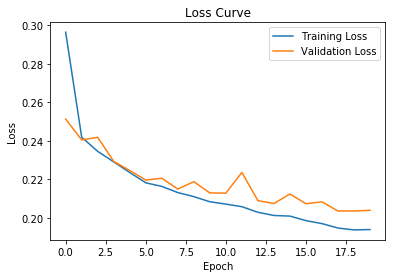

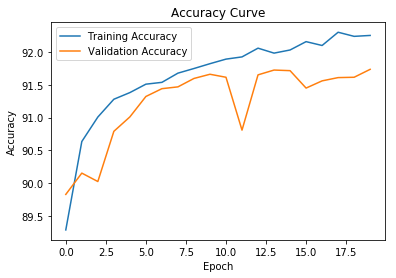

Test: [0/110]	Time 0.064 (0.064)	Loss 0.4121 (0.4121)	Accuracy 81.000 (81.000)
Test: [50/110]	Time 0.013 (0.014)	Loss 0.2485 (0.2151)	Accuracy 87.000 (91.431)
Test: [100/110]	Time 0.013 (0.014)	Loss 0.0592 (0.2069)	Accuracy 98.000 (91.644)


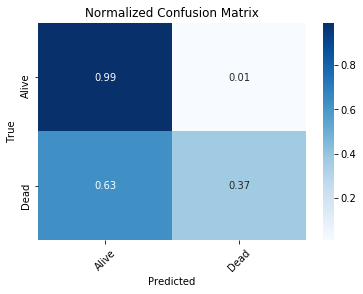

In [56]:
# train model

model = MyVariableRNN(num_features)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(PATH_OUTPUT, "MyVariableRNN_chartLab48.pth"))

best_model = torch.load(os.path.join(PATH_OUTPUT, "MyVariableRNN_chartLab48.pth"))
# TODO: For your report, try to make plots similar to those in the previous task.
# TODO: You may use the validation set in case you cannot use the test set.

plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)
valid_loss, valid_accuracy, valid_results = evaluate(best_model, device, valid_loader, criterion)
class_names = ['Alive', 'Dead']
plot_confusion_matrix(valid_results, class_names)

In [57]:
# prediction on test dataset
def predict_mortality(model, device, data_loader):
	model.eval()
	probas = []
	    
	for i, (inputs, targets) in enumerate(data_loader):
		outputs = model(inputs)
		probas.extend(torch.sigmoid(outputs)[:, 1])
  
	return probas

test_prob = predict_mortality(best_model, device, test_loader)

In [58]:
preds = [i.item() for i in test_prob]

In [59]:
import numpy as np
from sklearn import metrics
y = test_label
fpr, tpr, thresholds = metrics.roc_curve(y, preds, pos_label=1)
metrics.auc(fpr, tpr)

0.8993336693548388

In [60]:
metrics.roc_auc_score(y, preds)

0.8993336693548388